In [53]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import os
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
from tensorflow.python.keras import backend as K
from collections import Counter
import random

In [54]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available:  0


In [55]:
#Preprocessing

In [56]:
#Check images files

In [57]:
from PIL import Image
import os

def check_corrupt_images(folder_path):
    corrupt_images = []
    
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(folder_path, filename)
            try:
                # Try to open the image file
                with Image.open(file_path) as img:
                    img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError):
                # If an error occurs, add the file to the list of corrupt images
                corrupt_images.append(filename)
    
    return corrupt_images

In [58]:
folders = ['images' +os.sep +'test', 'images' +os.sep +'train']
subfolders = os.listdir('images' +os.sep +'test')
all_folders =[]
for sf in folders:
    for l in subfolders:
        all_folders.append(sf+os.sep +l)

for chk_f in all_folders:
    corrupt_images = check_corrupt_images(chk_f)
    if corrupt_images:
        print("Corrupt images found:")
        for img in corrupt_images:
            print(img)
    else:
        print("No corrupt images found.")

No corrupt images found.
No corrupt images found.
No corrupt images found.
No corrupt images found.
No corrupt images found.
No corrupt images found.
No corrupt images found.
No corrupt images found.
No corrupt images found.
No corrupt images found.
No corrupt images found.
No corrupt images found.
No corrupt images found.
No corrupt images found.


In [59]:
#Remove non relevant image

In [60]:
def analyze_images(image_folder):
    problem_images=[]
    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    if not image_files:
      print(f"No images found in {image_folder}")
      return

    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        try:
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

            if img is None:
                print(f"Error loading image: {image_file}")
                continue

            total_pixels = img.size
            n_nonwhite_pix = np.sum(img != 255)
            white_pixels = total_pixels - n_nonwhite_pix
            black_pixels = np.sum(img == 0)

            if white_pixels > total_pixels / 2 or black_pixels > total_pixels / 2:
                problem_images.append(image_path)
        except Exception as e:
            print(f"Error processing image {image_file}: {e}")
    return problem_images

In [61]:
def display_images(image_list, rows=3, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    for i, ax in enumerate(axes.flatten()):
        if i < len(image_list):
            img = mpimg.imread(image_list[i])
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

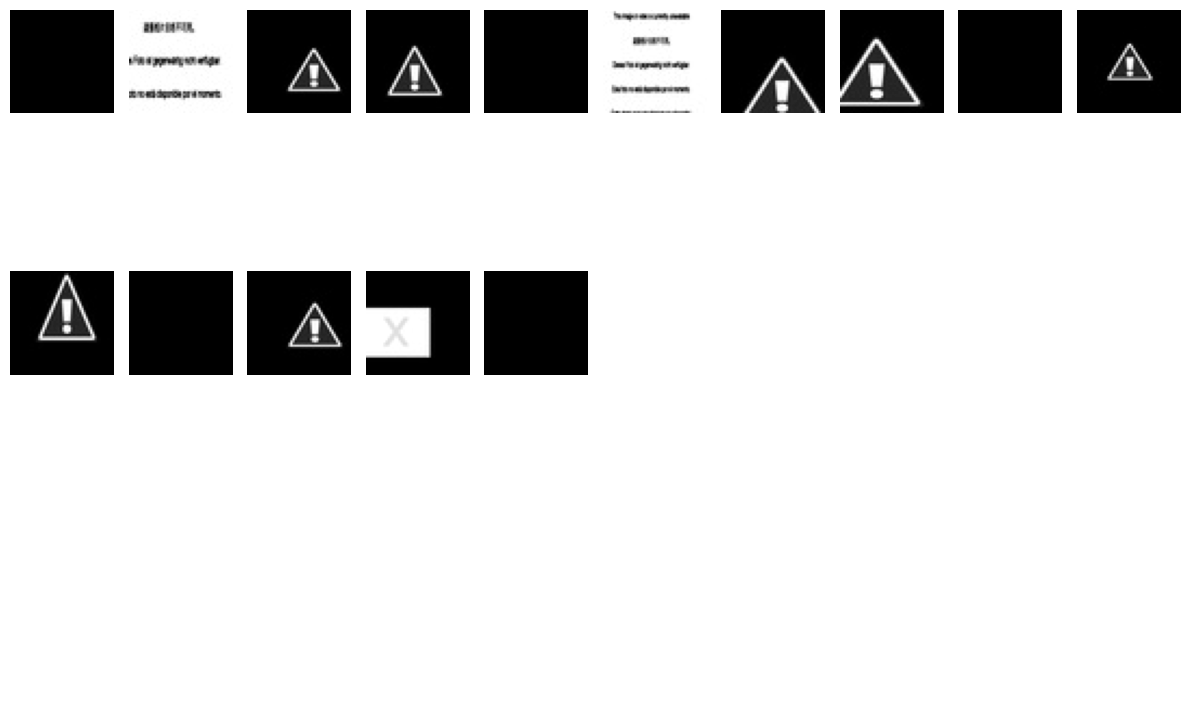

In [62]:
removeList = []
for folder in all_folders:
    removeList.extend(analyze_images(folder))

display_images(removeList)

In [63]:
print("Clean Dataset: ", removeList)
print("Size: ", len(removeList))


Clean Dataset:  ['images\\test\\angry\\PublicTest_5543497.jpg', 'images\\test\\fear\\PrivateTest_65872116.jpg', 'images\\test\\neutral\\PrivateTest_15353271.jpg', 'images\\test\\surprise\\PublicTest_53795000.jpg', 'images\\train\\angry\\Training_96772745.jpg', 'images\\train\\fear\\Training_1018372.jpg', 'images\\train\\fear\\Training_65365689.jpg', 'images\\train\\happy\\Training_19441677.jpg', 'images\\train\\happy\\Training_87607167.jpg', 'images\\train\\neutral\\Training_38142836.jpg', 'images\\train\\neutral\\Training_88342086.jpg', 'images\\train\\neutral\\Training_89335926.jpg', 'images\\train\\neutral\\Training_94337620.jpg', 'images\\train\\sad\\Training_87857337.jpg', 'images\\train\\surprise\\Training_48403842.jpg']
Size:  15


In [64]:
def remove_images(image_list):
    for image_path in image_list:
        try:
            os.remove(image_path)
            print(f"Removed: {image_path}")
        except OSError as e:
            print(f"Error removing {image_path}: {e}")

In [65]:
remove_images(removeList)

Removed: images\test\angry\PublicTest_5543497.jpg
Removed: images\test\fear\PrivateTest_65872116.jpg
Removed: images\test\neutral\PrivateTest_15353271.jpg
Removed: images\test\surprise\PublicTest_53795000.jpg
Removed: images\train\angry\Training_96772745.jpg
Removed: images\train\fear\Training_1018372.jpg
Removed: images\train\fear\Training_65365689.jpg
Removed: images\train\happy\Training_19441677.jpg
Removed: images\train\happy\Training_87607167.jpg
Removed: images\train\neutral\Training_38142836.jpg
Removed: images\train\neutral\Training_88342086.jpg
Removed: images\train\neutral\Training_89335926.jpg
Removed: images\train\neutral\Training_94337620.jpg
Removed: images\train\sad\Training_87857337.jpg
Removed: images\train\surprise\Training_48403842.jpg


In [66]:
# Load the dataset without any predefined batch size
train_data = tf.keras.utils.image_dataset_from_directory(
    'images/train',
    labels='inferred',
    label_mode='int',
    batch_size=None,  # Load as unbatched dataset
    image_size=(48, 48),  # Resize images to standard size
    seed=42 
)

Found 28689 files belonging to 7 classes.


In [67]:
test_data = keras.utils.image_dataset_from_directory(
    directory = 'images/test',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = 120,
    image_size = (48, 48),
    seed=42 
)

Found 7173 files belonging to 7 classes.


In [68]:
# Class names
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [69]:
# Extract data from train dataset
def extract_images_and_labels(dataset):
    X, y = [], []
    for image, label in dataset:
        X.append(image.numpy())
        y.append(label.numpy())
    return np.array(X), np.array(y)

# Assuming train_data is loaded correctly
X, y = extract_images_and_labels(train_data)

In [70]:
print(f'X shape before augmentation: {X.shape}')
print(f'y shape before augmentation: {y.shape}')

X shape before augmentation: (28689, 48, 48, 3)
y shape before augmentation: (28689,)


In [71]:
def data_augmentation(X, y, target_count=2000, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                      zoom_range=0.1, brightness_range=(0.95, 1.05), horizontal_flip=True, vertical_flip=True, fill_mode='nearest'):
    # Initialize ImageDataGenerator
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        brightness_range=brightness_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        fill_mode=fill_mode
    )

    balanced_X = []
    balanced_y = []
    
    unique_classes = np.unique(y)
    # For each class, augment until reaching the target count
    for class_label in unique_classes:
        class_indices = np.where(y == class_label)[0]
        class_images = X[class_indices]
        class_labels = y[class_indices]
        num_images = class_images.shape[0]

        # Calculate how many augmentations are needed
        augmentations_needed = target_count - num_images
        if augmentations_needed >0:
            # Add original images to balanced dataset
            balanced_X.extend(class_images)
            balanced_y.extend(class_labels)
    
            # Calculate how many augmentations are needed for this class
            augmentations_needed = target_count - num_images
    
            # Augment images until we reach the target count
            while augmentations_needed > 0:
                for img, label in zip(class_images, class_labels):
                    if augmentations_needed <= 0:
                        break
                    img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels)
                    label = label.reshape((1,))  # Reshape to a single label
                    augmented_img = next(datagen.flow(img))  # Generate an augmented image
                    balanced_X.append(augmented_img.squeeze())  # Add augmented image to list
                    balanced_y.append(label.squeeze())  # Add label to list
                    augmentations_needed -= 1
        else:
            balanced_X.extend(class_images[:target_count])
            balanced_y.extend(class_labels[:target_count])

    balanced_X = np.array(balanced_X)
    balanced_y = np.array(balanced_y)

    return balanced_X, balanced_y

In [72]:
X_augmented, y_augmented = data_augmentation(X, y, target_count=4000)

In [73]:
print(f'X shape after augmentation: {X_augmented.shape}')
print(f'y shape after augmentation: {y_augmented.shape}')

X shape after augmentation: (28000, 48, 48, 3)
y shape after augmentation: (28000,)


In [74]:
#convert to channel 1
X_augmented = X_augmented[:, :, :, [0]]

In [75]:
X_augmented.shape

(28000, 48, 48, 1)

In [76]:
Counter(y_augmented)

Counter({np.int32(0): 4000,
         np.int32(1): 4000,
         np.int32(2): 4000,
         np.int32(3): 4000,
         np.int32(4): 4000,
         np.int32(5): 4000,
         np.int32(6): 4000})

In [77]:
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array(X_augmented)  # Images
y = np.array(y_augmented)  # Labels

In [78]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=53)
train_idx, valid_idx = next(strat_split.split(X, y))
X_train = X[train_idx]
y_train = y[train_idx]
X_valid = X[valid_idx]
y_valid = y[valid_idx]

In [79]:
print(X_train.shape)
print(X_valid.shape)

(22400, 48, 48, 1)
(5600, 48, 48, 1)


In [80]:
num_classes = 7

In [81]:
model_file = "my_model.keras"

model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(48,48,1)))
model.add(Conv2D(32, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [82]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [83]:
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [84]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,813,095 (6.92 MB)

 Trainable params: 1,812,647 (6.91 MB)

 Non-trainable params: 448 (1.75 KB)

In [85]:
#Release memory
train_data =0
X = y = 0
balanced_X = balanced_y = 0
X_augmented = y_augmented = 0
final_dataset = 0

In [86]:
history = model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_valid,y_valid))

Epoch 1/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 55s 75ms/step - accuracy: 0.1786 - loss: 2.1728 - val_accuracy: 0.1434 - val_loss: 2.2270
Epoch 2/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step - accuracy: 0.2495 - loss: 1.8442 - val_accuracy: 0.2918 - val_loss: 1.7788
Epoch 3/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step - accuracy: 0.3241 - loss: 1.7150 - val_accuracy: 0.3505 - val_loss: 1.6796
Epoch 4/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step - accuracy: 0.3826 - loss: 1.6130 - val_accuracy: 0.3764 - val_loss: 1.5861
Epoch 5/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step - accuracy: 0.4118 - loss: 1.5301 - val_accuracy: 0.3900 - val_loss: 1.5785
Epoch 6/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - accuracy: 0.4230 - loss: 1.4775 - val_accuracy: 0.4341 - val_loss: 1.4723
Epoch 7/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - accuracy: 0.4530 - loss: 1.4188 - val_accuracy: 0.4545 - val_loss: 1.4123
Epoch 8/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - accuracy: 0.4696 - loss: 1.3691 - 

In [87]:
model.save(model_file)

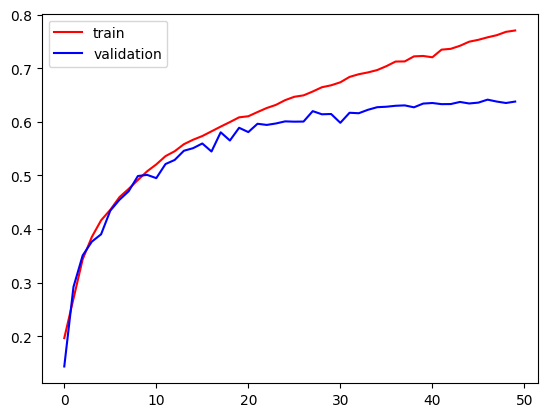

In [88]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

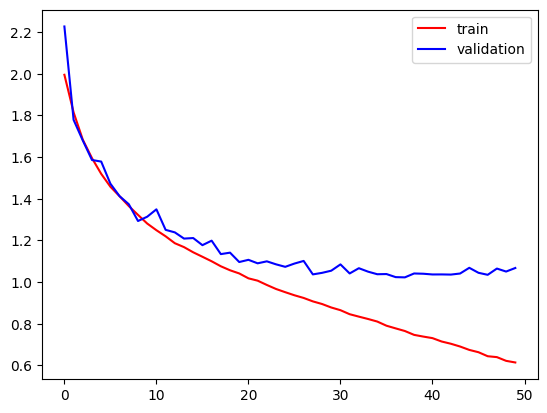

In [89]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

In [90]:
# Evaluate model
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6167 - loss: 1.1209
Test Accuracy: 61.34%


In [102]:
predictions = model.predict(test_data)

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step


In [115]:
predictions = np.argmax(predictions, axis=1)

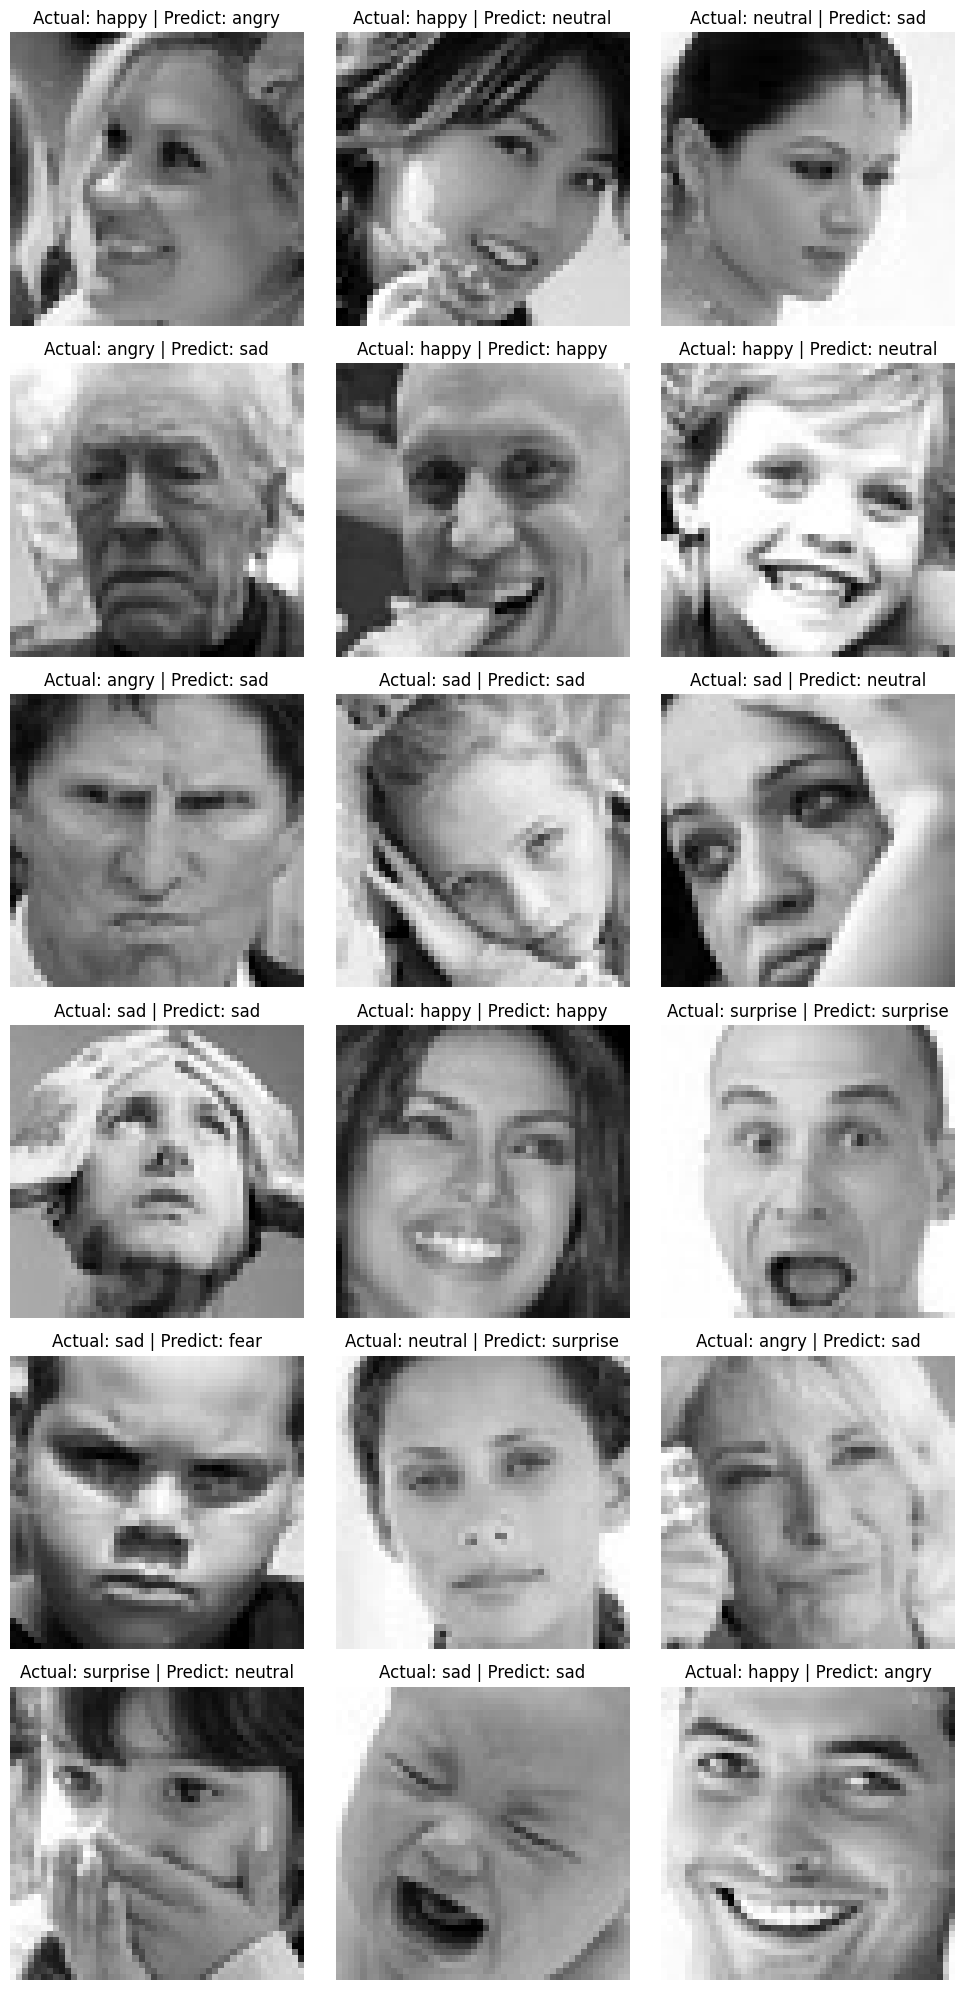

In [133]:
index = 0
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(10, 20))

for image, label in test_data.unbatch():
    label = label.numpy()

    # Access the current subplot from the flattened axes array
    ax = axes.flat[index]

    # Display the image with title and axis handling
    ax.imshow(image, cmap='gray')
    actual_class = class_names[label]
    predicted_class = class_names[predictions[index]]  # Assuming predictions is defined
    ax.set_title(f'Actual: {actual_class} | Predict: {predicted_class}')
    ax.axis('off')

    index += 1
    if (index >= 18):  # Adjust the limit based on desired number of images
        break

plt.tight_layout()
plt.show()